In [1]:
from synthcity_addons import generators
import openml
from sklearn.preprocessing import QuantileTransformer, StandardScaler
from synthcity_addons import GenericDataLoader
from utils import TabrQuantileTransformer
import numpy as np
import pandas as pd
from sklearn.datasets import make_moons

#normalization = "tabr_quantile"
normalization = "standard"
task_id = 361073
task = openml.tasks.get_task(task_id)
dataset = task.get_dataset()
dataset_name = dataset.name
# kwargs are the hyperparameters
hp_dic = {}
hp_dic.update({"strict": False})
print("hp_dic", hp_dic)
hp_dic_original = hp_dic.copy()
hp_str = "_".join([f"{k}_{v}" for k, v in hp_dic.items()]) # before it's modified by synthcity
X, y, _, _ = dataset.get_data(target=dataset.default_target_attribute)
# add target to X
X["target"] = y
# restrict X to 20K random samples
if X.shape[0] > 20000:
    X = X.sample(20000, random_state=42)

# restrict to 30 columns
#X = X.iloc[:, -30:]
X = X.iloc[:, :2]

# make a random 2d numerical + categorical
#X = pd.DataFrame(np.random.rand(3000, 2), columns=["x", "y"])
# make the second column categorical (ordinal 0, 1, 2)
#X["y"] = pd.cut(X["y"], bins=[0, 0.5, 0.8, 1], labels=[0, 1, 2])
#X["y"] = pd.cut(X["y"], bins=3, labels=[0, 1, 2])

# moon dataset
X, y = make_moons(n_samples=3000, noise=0.1)
X = pd.DataFrame(X, columns=["x", "y"])

print(X.columns)
if normalization == "quantile":
    X = QuantileTransformer(output_distribution="normal", random_state=42).set_output(transform="pandas").fit_transform(X)
elif normalization == "standard":
    X = StandardScaler().set_output(transform="pandas").fit_transform(X)
elif normalization == "tabr_quantile":
    X_ = TabrQuantileTransformer().fit_transform(X.to_numpy())
    # transform back to pandas
    X = pd.DataFrame(X_, columns=X.columns)

print(X)
# take 1024 random rows from X
indices = np.random.choice(X.index, 1024, replace=False)
X_ref = X.loc[indices]
X = X.drop(index=indices)

loader = GenericDataLoader(X, target_column="target")
loader_ref = GenericDataLoader(X_ref, target_column="target")

print("Loaded")

task_type = "regression"
synthetic_size = 512

[2024-07-09T15:54:48.965530+0200][837360][CRITICAL] module disabled: /data/parietal/store/work/lgrinszt/synthcity/src/synthcity/plugins/generic/plugin_goggle.py
INFO:datasets:PyTorch version 1.13.1 available.
INFO:torch.distributed.nn.jit.instantiator:Created a temporary directory at /tmp/tmpm6j46y4p
INFO:torch.distributed.nn.jit.instantiator:Writing /tmp/tmpm6j46y4p/_remote_module_non_scriptable.py
INFO:openml.config:No config file found at /home/soda/lgrinszt/.config/openml/config, using default configuration.
INFO:openml.datasets.dataset:pickle load data pol


hp_dic {'strict': False}
Index(['x', 'y'], dtype='object')
             x         y
0    -0.060054  1.074917
1     0.519392 -1.792132
2    -0.405659  1.476550
3    -0.508028 -0.239097
4    -0.025523 -0.866147
...        ...       ...
2995 -0.650071 -0.487847
2996  0.798813 -0.536465
2997  0.340292 -0.105888
2998  0.502258 -1.166931
2999 -0.697820  1.333742

[3000 rows x 2 columns]
Loaded


In [2]:
X

,x,y
1,0.519392,-1.792132
3,-0.508028,-0.239097
4,-0.025523,-0.866147
5,-1.478604,1.008565
6,-1.423915,0.371583
...,...,...
2994,-0.979824,1.175125
2995,-0.650071,-0.487847
2996,0.798813,-0.536465
2998,0.502258,-1.166931


In [3]:
# plt.scatter(X.iloc[:, 0], X.iloc[:, 1], color="blue", label="True", alpha=0.5)
# plt.show()

In [7]:
from synthcity.plugins import Plugins
hp_dic["n_batches"] = 100
hp_dic["n_permutations"] = 5
hp_dic["n_ensembles"] = 5
#hp_dic["initialization_strategy"] =  Plugins().get("smote", strict=False)
hp_dic["preprocessing"] = "none"
hp_dic["noise_std"] = 0.1
hp_dic["lr"] = 0.0001
hp_dic["n_test_from_false_train"] = 256
hp_dic["store_intermediate_data"] = True
hp_dic["task_type"] = "regression"
#hp_dic["use_wasserstein"] = True
hp_dic["store_animation_path"] = "animation_2.mp4"
hp_dic["strict"] = False
plugin = Plugins().get("tabpfn_points", **hp_dic)
#plugin = Plugins().get("ddpm")

[2024-07-09T15:55:30.310565+0200][837360][CRITICAL] module disabled: /data/parietal/store/work/lgrinszt/synthcity/src/synthcity/plugins/generic/plugin_goggle.py


In [5]:
plugin.fit(X)

encoders None
self.task_type classification
X_true [[ 0.519392  ]
 [-0.50802789]
 [-0.02552308]
 ...
 [ 0.79881255]
 [ 0.50225831]
 [-0.69781976]]


  0%|          | 0/100 [00:00<?, ?it/s]


RuntimeError: Sizes of tensors must match except in dimension 0. Expected size 1 but got size 2 for tensor number 1 in the list.

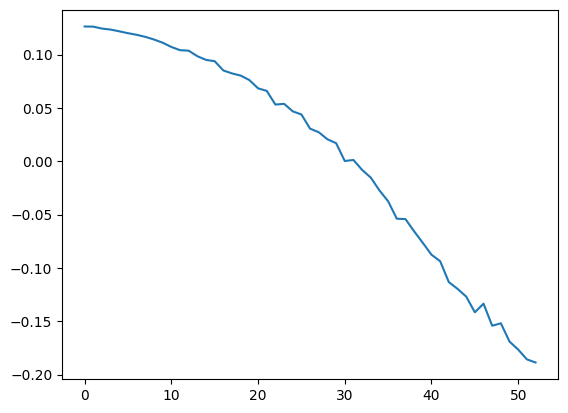

In [ ]:
import matplotlib.pyplot as plt
plt.plot(np.log10(plugin.loss_list))

In [6]:
plt.plot(plugin.accuracy_list)

NameError: name 'plt' is not defined

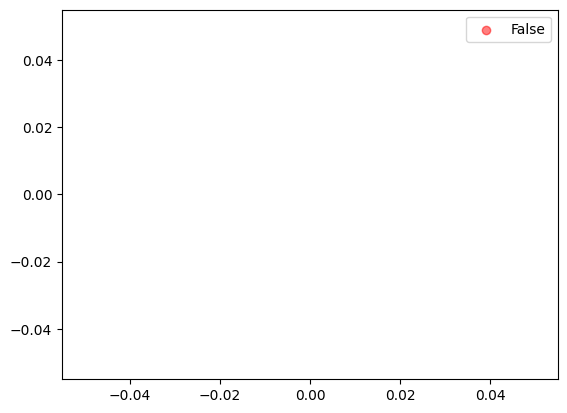

In [8]:
X_false_init = plugin.all_X_false_train[-1]
plt.scatter(X_false_init[:, 0], X_false_init[:, 1], color="red", label="False", alpha=0.5)
#plt.scatter(X.iloc[:, 0], X.iloc[:, 1], color="blue", label="True", alpha=0.5)
plt.legend()
plt.show()

In [6]:
X_false_tabpfn = plugin.generate(512).numpy()

In [17]:
import ot
M = ot.dist(X.to_numpy(), X_false_tabpfn, metric='euclidean')
a = np.ones((X.shape[0],)) / X.shape[0]
b = np.ones((X_false_tabpfn.shape[0],)) / X_false_tabpfn.shape[0]
reg = 1e-1  # Regularization parameter for Sinkhorn algorithm
loss = ot.sinkhorn2(a, b, M, reg)
# compute another way
#loss = ot.emd2(a, b, M)
print("loss", loss)

loss 8.134153320532757e-73


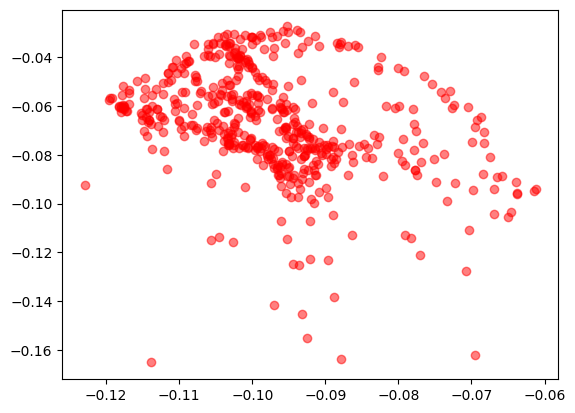

In [9]:
import matplotlib.pyplot as plt
plt.scatter(X_false_tabpfn[:, 0], X_false_tabpfn[:, 1], color="red", label="False", alpha=0.5)
plt.show()

In [29]:
# find the unique values in the second column of X_false_tabpfn
unique_values = np.unique(X.iloc[:, 1])
print(unique_values)
# compute 2 thresholds between the 3 unique values
thresholds = np.percentile(unique_values, [25, 75])
print(thresholds)
# compute the number of unique values in X_false_tabpfn that are in the three classes
print(np.sum((X_false_tabpfn[:, 1] < thresholds[0])))
print(np.sum((X_false_tabpfn[:, 1] > thresholds[0]) & (X_false_tabpfn[:, 1] < thresholds[1])))
print(np.sum((X_false_tabpfn[:, 1] > thresholds[1])))
# same for X
print(np.sum((X.iloc[:, 1] < thresholds[0])))
print(np.sum((X.iloc[:, 1] > thresholds[0]) & (X.iloc[:, 1] < thresholds[1])))
print(np.sum((X.iloc[:, 1] > thresholds[1])))


[-2.0050054  -1.98613908 -1.95884429 ...  1.87737903  1.91719891
  2.07694524]
[-0.89042332  0.87796696]
127
261
124
494
988
494


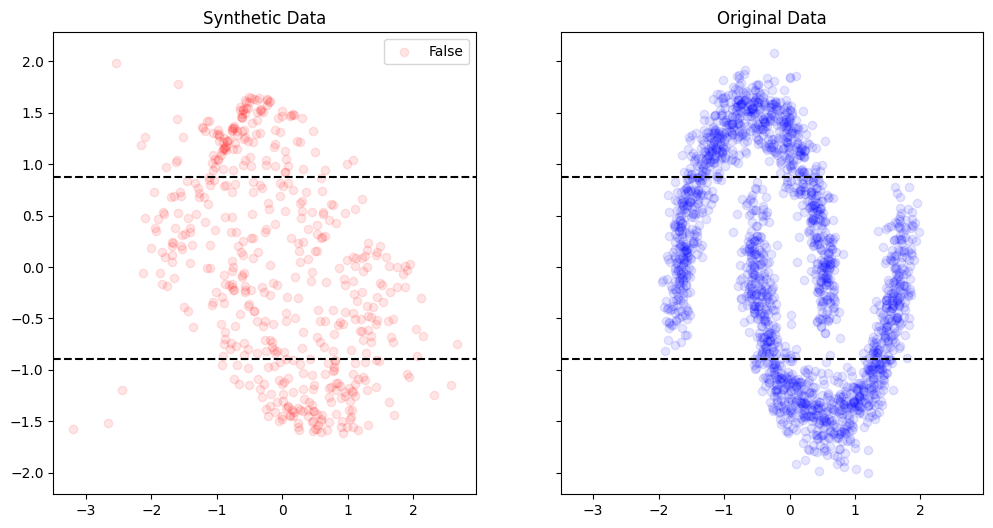

In [30]:
import matplotlib.pyplot as plt
dims = 0, 1
fig, (ax1, ax2) = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(12, 6))

ax1.scatter(X_false_tabpfn[:, dims[0]], X_false_tabpfn[:, dims[1]], color="red", label="False", alpha=0.1)
# horizontal lines at the thresholds
ax1.axhline(y=thresholds[0], color="black", linestyle="--")
ax1.axhline(y=thresholds[1], color="black", linestyle="--")
ax1.set_title("Synthetic Data")
ax1.legend()

ax2.scatter(X.to_numpy()[:, dims[0]], X.to_numpy()[:, dims[1]], color="blue", alpha=0.1)
ax2.axhline(y=thresholds[0], color="black", linestyle="--")
ax2.axhline(y=thresholds[1], color="black", linestyle="--")
ax2.set_title("Original Data")

plt.show()


Model accuracy: 0.5219512195121951


(array([[1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 3., 1., 0.,
         2., 2., 1., 1., 2., 0., 1., 1., 2., 1., 3., 1., 0., 3., 2., 2.,
         4., 2., 2., 6., 2., 7., 4., 6., 1., 3., 2., 1., 3., 2., 4., 4.,
         5., 9., 4., 5., 4., 2., 5., 7., 6., 5., 6., 3., 5., 4., 5., 5.,
         5., 5., 7., 8., 4., 3., 0., 0., 3., 0., 5., 1., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 1., 5., 0., 3., 0., 0., 3., 4.,
         8., 7., 5., 5., 5., 5., 4., 5., 3., 6., 5., 6., 7., 5., 2., 4.,
         5., 4., 9., 5., 4., 4., 2., 3., 1., 2., 3., 1., 6., 4., 7., 2.,
         6., 2., 2., 4., 2., 2., 3., 0., 1., 3., 1., 2., 1., 1., 0., 2.,
         1., 1., 2., 2., 0., 1., 3., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
         1., 0., 0., 1.]]),
 array([0.47389784, 0.47441989, 0.47494194, 0.47546399, 0.475986  ,
  

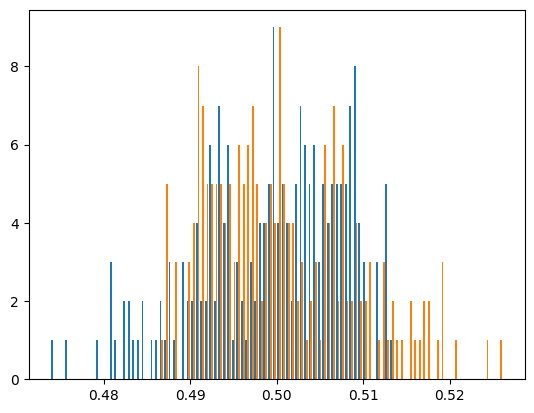

In [44]:
from tabpfn import TabPFNClassifier

model = TabPFNClassifier(normalize=False, no_preprocess_mode=True)
#model = TabPFNClassifier()

# Train the model to see if it can discriminate between true and false data
y_true = np.ones(X_false_tabpfn.shape[0])
y_false = np.zeros(X_false_tabpfn.shape[0])

X_combined = np.vstack((X.to_numpy()[:X_false_tabpfn.shape[0]], X_false_tabpfn))
y_combined = np.hstack((y_true, y_false))

# train test split
from sklearn.model_selection import train_test_split

# Split the combined data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_combined, y_combined, test_size=0.2, random_state=42)

# Fit the model on the training data
model.fit(X_train, y_train)

# Evaluate the model on the testing data
accuracy = model.score(X_test, y_test)
print(f"Model accuracy: {accuracy}")

# show the proba distribution
probs = model.predict_proba(X_test)
plt.hist(probs, bins=100)



NORMALIZING
NORMALIZING
Model accuracy: 0.5024390243902439
NORMALIZING
NORMALIZING


(array([[ 0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,
          0.,  0.,  1.,  1.,  2.,  0.,  1.,  1.,  0.,  0.,  1.,  4.,  1.,
          0.,  2.,  0.,  0.,  1.,  2.,  3.,  1.,  2.,  5.,  4.,  2.,  7.,
          3.,  8.,  9.,  7.,  3.,  7.,  3.,  4.,  5., 10.,  2.,  3., 10.,
         12.,  7.,  1.,  1.,  3.,  5.,  4.,  6.,  5.,  1.,  1.,  1.,  0.,
          1.,  1.,  4.,  4.,  0.,  1.,  0.,  1.,  1.,  0.,  0.,  1.,  0.,
          0.,  0.,  0.,  0.,  1.,  0.,  0.,  1.,  0.,  1.,  1.,  1.,  6.,
          6.,  2.,  0.,  0.,  1.,  2.,  2.,  1.,  2.],
        [ 2.,  1.,  2.,  2.,  1.,  0.,  0.,  2.,  6.,  6.,  1.,  1.,  1.,
          0.,  1.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,
          1.,  1.,  0.,  1.,  0.,  4.,  4.,  1.,  1.,  0.,  1.,  1.,  1.,
          5.,  6.,  4.,  5.,  3.,  1.,  1.,  7., 12., 10.,  3.,  2., 10.,
          5.,  4.,  3.,  7.,  3.,  7.,  9.,  8.,  3.,  7.,  2.,  4.,  5.,
          2.,  1.,  3.,  2.,  1.,  0.,  0.,  2.,  0.,  1.

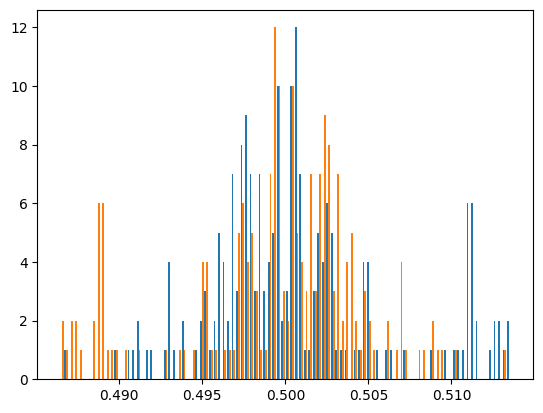

In [33]:
from tabpfn import TabPFNClassifier

#model = TabPFNClassifier(normalize=False, no_preprocess_mode=True)
model = TabPFNClassifier()

# Train the model to see if it can discriminate between true and false data
y_true = np.ones(512)
y_false = np.zeros(512)

X_combined = np.vstack((X.to_numpy()[:512], X_ref.to_numpy()[:512]))
y_combined = np.hstack((y_true, y_false))

# train test split
from sklearn.model_selection import train_test_split

# Split the combined data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_combined, y_combined, test_size=0.2, random_state=42)

# Fit the model on the training data
model.fit(X_train, y_train)

# Evaluate the model on the testing data
accuracy = model.score(X_test, y_test)
print(f"Model accuracy: {accuracy}")

# show the proba distribution
probs = model.predict_proba(X_test)
plt.hist(probs, bins=100)



NameError: name 'X_false' is not defined

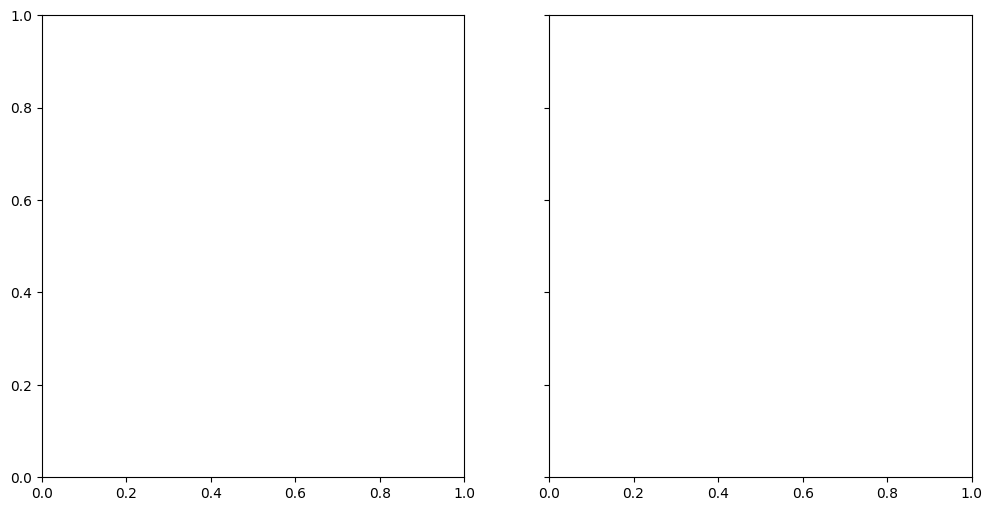

In [23]:
import matplotlib.pyplot as plt
dims = 0, 1
fig, (ax1, ax2) = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(12, 6))

ax1.scatter(X_false[:, dims[0]], X_false[:, dims[1]], color="red", label="False", alpha=0.5)
ax1.set_title("Synthetic Data")
ax1.legend()

ax2.scatter(X.to_numpy()[:, dims[0]], X.to_numpy()[:, dims[1]], color="blue", alpha=0.1)
ax2.set_title("Original Data")

plt.show()


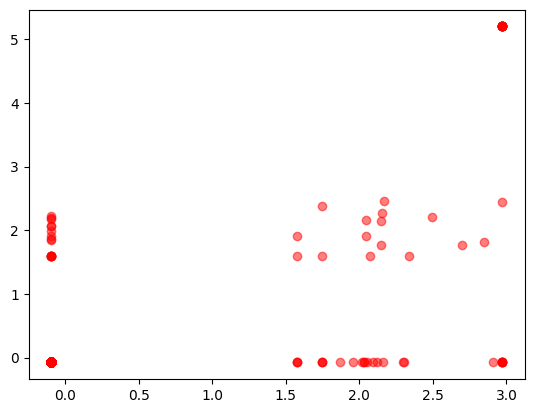

In [40]:
plt.scatter(X_false[:, dims[0]], X_false[:, dims[1]], color="red", label="False", alpha=0.5)

(array([1.3013e+04, 0.0000e+00, 0.0000e+00, 6.5500e+02, 2.3000e+02,
        7.7000e+01, 0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00]),
 array([-0.08694499,  0.44168327,  0.97031153,  1.49893978,  2.02756804,
         2.5561963 ,  3.08482455,  3.61345281,  4.14208107,  4.67070933,
         5.19933758]),
 <BarContainer object of 10 artists>)

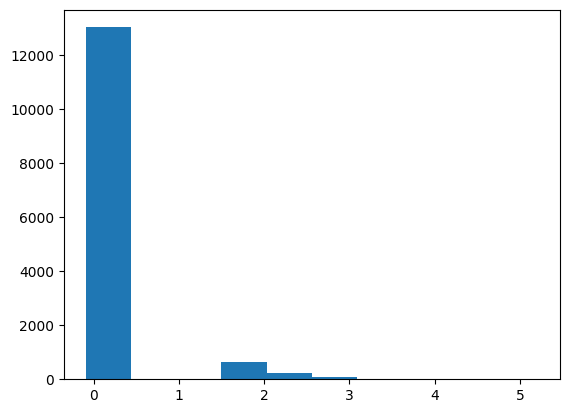

In [28]:
plt.hist(X.to_numpy()[:, dims[0]])

In [19]:
num_unique_rows = len(np.unique(plugin.X_false_train.cpu().detach().numpy(), axis=0))
print(f"Number of unique rows in X_false: {num_unique_rows}")

Number of unique rows in X_false: 512


In [1]:
from synthcity_addons import generators
import numpy as np
from synthcity_addons import GenericDataLoader, Plugins

# change seed
np.random.seed(20)

X = np.random.rand(10, 2)
X_ref = np.random.rand(10, 2)

loader = GenericDataLoader(X)
loader_ref = GenericDataLoader(X_ref)

syn_model = Plugins().get("oracle", strict=False)
syn_model.fit(loader, loader_ref)

false_data = syn_model.generate(14)
# show the number of duplicates in false_data
s = 0
for i in range(false_data.numpy().shape[0]):
    for j in range(i+1, false_data.numpy().shape[0]):
        if np.all(false_data.numpy()[i] == false_data.numpy()[j]):
            s += 1
print(s)

[KeOps] Warning : Cuda libraries were not detected on the system or could not be loaded ; using cpu only mode


[2024-07-05T16:36:17.361789+0200][3623684][CRITICAL] module disabled: /data/parietal/store/work/lgrinszt/synthcity/src/synthcity/plugins/generic/plugin_goggle.py
INFO:datasets:PyTorch version 1.13.1 available.
INFO:torch.distributed.nn.jit.instantiator:Created a temporary directory at /tmp/tmpaiq9s4ko
INFO:torch.distributed.nn.jit.instantiator:Writing /tmp/tmpaiq9s4ko/_remote_module_non_scriptable.py
[2024-07-05T16:36:20.060640+0200][3623684][CRITICAL] module disabled: /data/parietal/store/work/lgrinszt/synthcity/src/synthcity/plugins/generic/plugin_goggle.py


encoders None
4


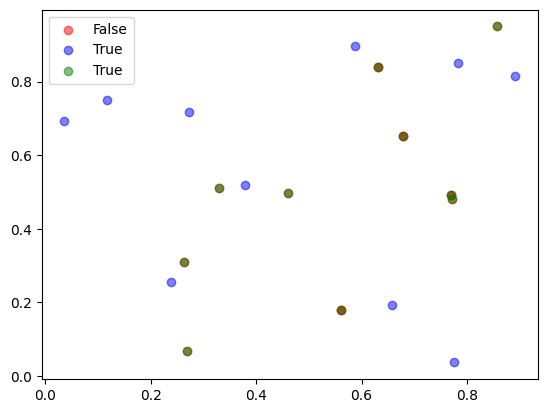

In [2]:
import matplotlib.pyplot as plt

plt.scatter(false_data.numpy()[:, 0], false_data.numpy()[:, 1], color="red", label="False", alpha=0.5)
plt.scatter(X[:, 0], X[:, 1], color="blue", label="True", alpha=0.5)
plt.scatter(X_ref[:, 0], X_ref[:, 1], color="green", label="True", alpha=0.5)
plt.legend()
plt.show()

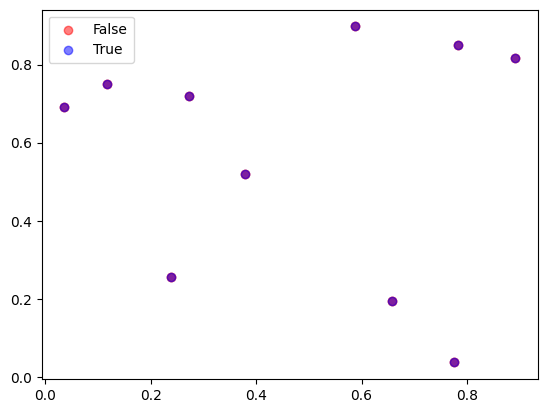

In [37]:
import matplotlib.pyplot as plt

plt.scatter(false_data.numpy()[:, 0], false_data.numpy()[:, 1], color="red", label="False", alpha=0.5)
plt.scatter(X[:, 0], X[:, 1], color="blue", label="True", alpha=0.5)
plt.legend()
plt.show()